In [61]:
import pandas as pd

# Load the Excel file (replace 'your_file.xlsx' with your actual file path)
FILE='20250507_XLMS_insolution_3.xlsx'
df = pd.read_excel(FILE)

# Define the columns of interest
group_cols = [
    'Protein Accession A', 'Leading Protein Position A',
    'Protein Accession B', 'Leading Protein Position B'
]

# Group by the specified columns
grouped = df.groupby(group_cols)

# Aggregate: count occurrences and get max XlinkX Score
summary = grouped.agg(
    Occurrences=('XlinkX Score', 'count'),
    Max_XlinkX_Score=('XlinkX Score', 'max')
).reset_index()

# Create a set of tuples as required
result_set = {
    (
        row['Protein Accession A'], row['Leading Protein Position A'],
        row['Protein Accession B'], row['Leading Protein Position B'],
        row['Occurrences'], row['Max_XlinkX_Score']
    )
    for _, row in summary.iterrows()
}

sorted_result = sorted(
    result_set,
    key=lambda x: (x[0], x[2], x[1], x[3])  # sort by Protein Accession A, then Leading Protein Position A
)


from collections import defaultdict

# Step 1: Normalize crosslink key to handle inversion
def normalize_key(a, x, b, y):
    return (a, x, b, y) if (a, x) <= (b, y) else (b, y, a, x)

# Step 2: Merge inverted pairs
merged_dict = defaultdict(lambda: [0, 0.0])  # {normalized_key: [total_occurrence, max_score]}

for a, x, b, y, occ, score in result_set:
    key = normalize_key(a, x, b, y)
    merged_dict[key][0] += occ  # sum occurrences
    merged_dict[key][1] = max(merged_dict[key][1], score)  # max score

# Step 3: Convert to final list of merged tuples
merged_result = [
    (a, x, b, y, occ, score)
    for (a, x, b, y), (occ, score) in merged_dict.items()
]

# Optional: Sort the merged list
merged_result_sorted = sorted(merged_result, key=lambda x: (x[0], x[1]))

# Print result
for item in merged_result_sorted:
    print(item)

print(len(merged_result_sorted))


('Q16531', 53, 'Q16531', 1063, 7, 50.34)
('Q16531', 70, 'Q16531', 150, 16, 55.68)
('Q16531', 70, 'Q96SW2', 116, 4, 38.13)
('Q16531', 70, 'Q96SW2', 166, 1, 22.53)
('Q16531', 92, 'Q16531', 1063, 6, 57.74)
('Q16531', 92, 'Q16531', 1067, 7, 74.42)
('Q16531', 92, 'Q16531', 150, 20, 73.62)
('Q16531', 141, 'Q16531', 153, 8, 66.07)
('Q16531', 150, 'Q16531', 1067, 27, 55.68)
('Q16531', 150, 'Q16531', 1063, 12, 38.96)
('Q16531', 150, 'Q16531', 200, 1, 18.98)
('Q16531', 153, 'Q16531', 1121, 1, 22.53)
('Q16531', 153, 'Q96SW2', 166, 2, 36.56)
('Q16531', 153, 'Q96SW2', 231, 1, 15.57)
('Q16531', 153, 'Q16531', 200, 23, 57.94)
('Q16531', 191, 'Q16531', 204, 15, 59.56)
('Q16531', 200, 'Q96SW2', 166, 1, 18.2)
('Q16531', 200, 'Q16531', 1067, 1, 17.99)
('Q16531', 200, 'Q96SW2', 116, 1, 16.36)
('Q16531', 254, 'Q96SW2', 211, 6, 76.85)
('Q16531', 254, 'Q96SW2', 226, 25, 67.68)
('Q16531', 254, 'Q96SW2', 222, 9, 107.49)
('Q16531', 254, 'Q96SW2', 156, 1, 15.57)
('Q16531', 823, 'Q16531', 897, 14, 116.55)
('Q1653

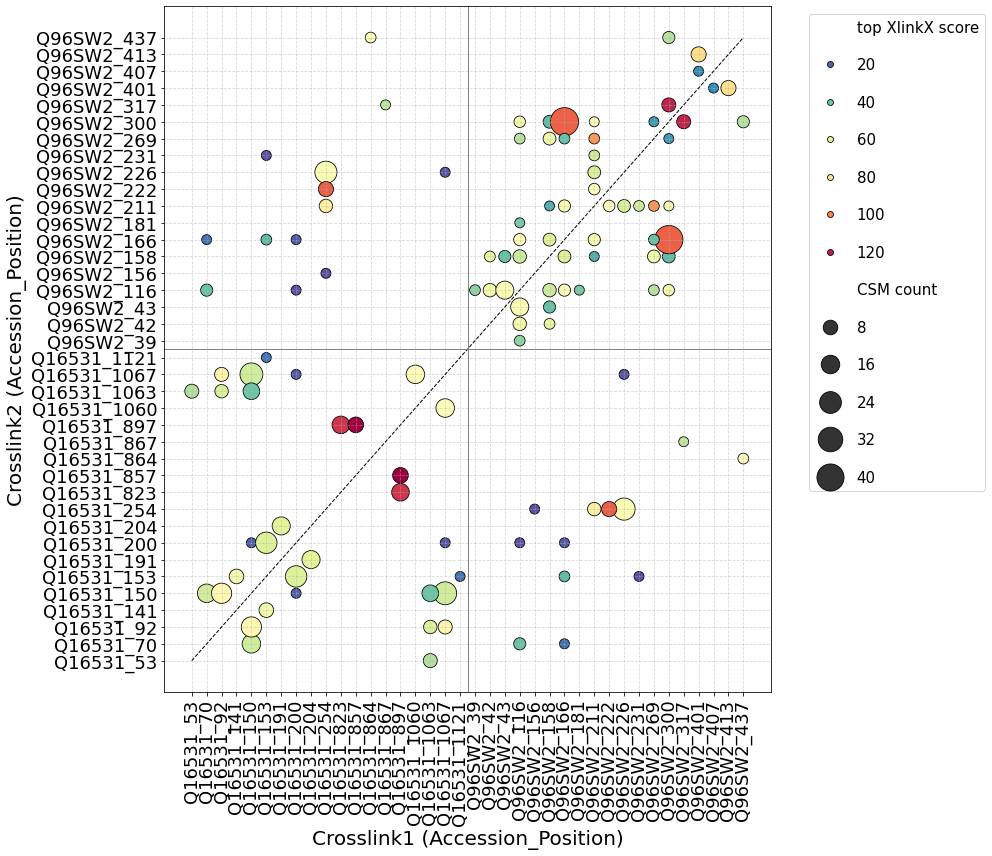

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame
df = pd.DataFrame(merged_result_sorted, columns=["accA", "posA", "accB", "posB", "CSM count", "top XlinkX score"])
df["a_x"] = df["accA"] + "_" + df["posA"].astype(str)
df["b_y"] = df["accB"] + "_" + df["posB"].astype(str)

# Prepare long format for symmetric plotting (so both A vs B and B vs A are shown)
df_long = pd.concat([
    df[['a_x', 'b_y', 'CSM count', 'top XlinkX score']],
    df.rename(columns={'a_x': 'b_y', 'b_y': 'a_x'})[['a_x', 'b_y', 'CSM count', 'top XlinkX score']]
])

# Create ordered tick list from all a_x and b_y values
tick_set = set(df["a_x"]).union(set(df["b_y"]))
tick_list_sorted = sorted(tick_set, key=lambda s: (s.split("_")[0], int(s.split("_")[1])))

# Convert a_x and b_y to ordered categorical types
df_long["a_x"] = pd.Categorical(df_long["a_x"], categories=tick_list_sorted, ordered=True)
df_long["b_y"] = pd.Categorical(df_long["b_y"], categories=tick_list_sorted[::-1], ordered=True)

# Plot
plt.figure(figsize=(14, 12))
bubble = sns.scatterplot(
    data=df_long,
    x="a_x",
    y="b_y",
    size="CSM count",
    hue="top XlinkX score",
    palette="Spectral_r",
    sizes=(100, 800),
    edgecolor="black",
    legend="auto",
)
bubble.grid(True, which='major', axis='both', linestyle='--', alpha=0.5)

# Plot y=x line
tick_indices = list(range(len(tick_list_sorted)))
for i in tick_indices:
    bubble.plot([i], [len(tick_list_sorted) - 1 - i], marker='o', markersize=0, color='black')
bubble.plot(tick_indices, [len(tick_list_sorted) - 1 - i for i in tick_indices], color='black', linewidth=1, linestyle='--')

# Separate A and B protein
all_ticks = df_long["a_x"].cat.categories
accessions = sorted(set(tick.split("_")[0] for tick in all_ticks))
a_x_ticks = [tick for tick in all_ticks if tick.startswith(accessions[0] + "_")]
# Find switch index in the tick list
switch_index = len(a_x_ticks)
# Vertical and horizontal line positions
plt.axvline(x=switch_index - 0.5, color='gray', linestyle='-', linewidth=1)
plt.axhline(y=len(all_ticks) - switch_index - 0.5, color='gray', linestyle='-', linewidth=1)


# Axis labeling and ticks
plt.xlabel('Crosslink1 (Accession_Position)', fontsize=20)
plt.ylabel('Crosslink2 (Accession_Position)', fontsize=20)
plt.xticks(rotation=90,size=18)
plt.yticks(size=18)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',labelspacing=1.5, prop={'size': 15})
plt.tight_layout()
plt.savefig(FILE+".png")
plt.show()